# Compartmental models on Graphs
This is an implementation to model contagion from cluster to cluster of disease. On each cluster there is a compartmental SEIR model.

## The Node function

Each cluster is denoted by $\mathcal{n}_i$ and contains a compartmental SEIR model:


\begin{align}
    \frac{dS(t)}{dt} & = \quad -r_{S\rightarrow E} \,  & \cdot S \cdot I &\quad + &\quad r_{R\rightarrow S} \cdot R\\ 
    \frac{dE(t)}{dt} & = \quad +r_{S\rightarrow E} \, & \cdot S \cdot I  &\quad - &\quad  r_{E \rightarrow I} \cdot E\\
    \frac{dI(t)}{dt} & = \quad +r_{E \rightarrow I} \, &  \cdot E     &\quad - &\quad r_{I \rightarrow R} \cdot I \\
    \frac{dR(t)}{dt} & = \quad +r_{I \rightarrow R} \, &  \cdot I     &\quad - &\quad r_{R\rightarrow S} \cdot R\\
\end{align}

In essence each compartmental model is also a graph but for simplicity and easier calibration with per-city/per-country data I chose to keep the SEIR model as is in the node. Each node may have different initial conditions, and different contagion dynamics controlled by how people go about their daily lives. For example in Switzerland where public transportation is common higher local contagion rates are expected than in US cities. 

If COVID19 contagion turns out to depend on weather/heat conditions, each node can have an interpolated or functional state denoting the local weather conditions, thus making predictions more reliable. Finally, the model may assess in a global network sense the effect of the following:
* effect of travel bans
* effect of localized quarantines
* "Milano effect" where people started leaving the city when quarantine measures were being discussed to other cities. This was also observed in Switzerland and Greece (own observations)

Information for the fitting of the model can be found in several sources including:
* Location services (Google maps data/ Google location services)
* Population densities
* Toll posts
* Train occupancy statistics



## The edge function
On the graph nodes an *edge function* that simulates the contagion from cluster to cluster is used.
The model assumes a matrix function $\mathcal{E}_{ij}$ that simulates the transfer between nodes $i$ and $j$. 

## What/How can be implemented
Assuming an $R_0$ value for a specific contagion cluster, we can put an edge function that can model
* the different ratios of people from each compartment of the cluster (S,E,I,R) leaving the cluster (edge matrix is a diagonal one)
* whether an infected (I) or exposed (E) individual is less likely to travel (the diagonal entry in the edge matrix corresponding to (E) or (I) is higher
* different and/or non-linear connections between clusters. For example it may be that people movement from a compartment during quarantine rumors are higher and un-restricted but when quarantine measures kick-in it is restricted/blocked. This would make the edge matrix non-diagonal, with a positive non-diagonal entry corresponding to the 
* simulating the effect of infected people traveling in public transportation. Contagion should be more probable for the individuals traveling in public transportation than personal transport.

## What is needed for model calibration
Approximate values of the transportation between to/from big cities (the nodes in the graph). This affects the edge values. This can be calibrated 

# Goal
* Use the reported data to assess changes in the basic reproductive rate and the effectiveness of measures meso/macroscopically. 
* Provide with short/medium term predictions of basic reproduction rate (week ~ month scale) and uncertainty bounds for model outputs in order to assess the safety of traveling to different regions or the effect traveling may have.

In [1]:
import numpy as np
import matplotlib.pyplot as pplot
import pandas as pd
# Recovery rate in days: current estimate of full recovery time is 14 days
def make_SEIRModel_fn(rse,rrs,rei, rir):
    #assert(r_ir+r_rs == 1.)
    def SEIR_node_deriv(S, time):
        
        xs,xe,xi,xr = S
        rse_xsi = rse*xs*xi
        rei_xe = rei * xe
        rrs_xr = rrs * xr
        rir_xi = rir * xi
        d_xs = - rse_xsi   + rrs_xr
        d_xe = + rse_xsi   - rei_xe
        d_xi = + rei_xe    - rir_xi
        d_xr =   rir_xi    - rrs_xr
        
        return [d_xs , d_xe, d_xi, d_xr]
    return SEIR_node_deriv

# Recovery rate in days: current estimate of full recovery time is 14 days
def make_SEIRN_Model_fn(rse,rrs,rei, rir):
    #assert(r_ir+r_rs == 1.)
    def SEIR_node_deriv(S, time):
        
        #S[S<0] = 0
        xs,xe,xi,xr,N = S
        rse_xsi = rse*xs*xi
        rei_xe = rei * xe
        rrs_xr = rrs * xr
        rir_xi = rir * xi
        d_xs = - rse_xsi   + rrs_xr
        d_xe = + rse_xsi   - rei_xe
        d_xi = + rei_xe    - rir_xi
        d_xr =   rir_xi    - rrs_xr
        d_N  = 0. # used to model effect of in/out coming "state". Affected by edges (derivative computed at graph level)
        
        return [d_xs , d_xe, d_xi, d_xr, d_N]
    return SEIR_node_deriv


## Keeping the scheme conservative in the presence of edges
In order to explicitly conserve the population in the numerical scheme, it is necessary that I add as many "compartments" as I remove from each node. This is implemented as such:

\begin{align}
\frac{d\mathbf{x}^A}{dt} &= F(\mathbf{x}^A) + G^{A \rightarrow B}_A(\mathbf{x}^A,\mathbf{x}^B,\mathcal{E}_{A \rightarrow B})\\
\frac{d\mathbf{x}^B}{dt} & = F(\mathbf{x}^B) + G^{B \rightarrow A}_B(\mathbf{x}^A,\mathbf{x}^B, \mathcal{E}_{B \rightarrow A})\\
\end{align}

with

\begin{equation}
G^{A \rightarrow B}_B(\mathbf{x}^A,\mathbf{x}^B, \mathcal{E}_{A \rightarrow B}) = - G^{B \rightarrow A}_A(\mathbf{x}^A,\mathbf{x}^B, \mathcal{E}_{B \rightarrow A})
\end{equation}

the graph function which affects variables both in source and destination node. $E_{A \rightarrow B}$ denotes other possible edge properties.

In [263]:

# A dynamic graph model for disease contagion and outbreak simulation
# The assumption is that each SEIR node has some evolution and communicates with another node.

    
# node_state : SEIR-N
# N: The total population at any moment in the cluster. 
#    Used to calibrate the "strength" of an edge.
# 
# This is needed for normalization of the effect of population movements.

class SEIRN_Node:
    def __init__(self, node_state,  params):
        """
        SEIRN variables embedded in a node.
        S: susceptible
        E: Exposed
        I: Infectious
        R: Recovered
        N: Population in the node.
        """
        
        self.state_names = ['S','E','I','R','N']
        
        if isinstance(node_state, list):
            node_state = np.array(node_state)
            
        self.node_state = node_state
        self.state_size = node_state.shape;
        
        self.params = params
        self.edge_reduce_buffer = [];
        self.node_model_deriv_fn  = make_SEIRN_Model_fn(*params)
        
    def get_state(self):
        return self.node_state;
    
    def seed_with_people(self, nseed):
        """
        Seed city with infected
        """
        N_curr = self.node_state[-1]
        N_new = N_curr + nseed
        self.node_state[0] = ((self.node_state[0] * N_curr) - nseed)/N_new # The "S" compartment
        self.node_state[2] = ((self.node_state[2] * N_curr) + nseed)/N_new # The "I" compartment
    
    def get_named_state(self, state_name):
        return self.node_state[self.state_names.index(state_name)]
    
    def set_state(self,node_state):
        self.node_state = node_state
    
    def node_out_function(self,edge_function_output):
        return self.node_state()
    
    def node_derivative_function(self,t):
        return self.node_model_deriv_fn(self.get_state(),t)
    
    def node_reduce_edge_dF(self):
        """
        Reduce the edge inputs to this node (after the "edge" compute step)
        """
        
        # These are unnormalized values:
        node_dF_sum = 0
        if self.edge_reduce_buffer is not []:
            node_dF_sum += np.sum(self.edge_reduce_buffer,0)
        
        # normalize the sums:
        #Ntot_prev = self.get_named_state("N")
        #Ntot_new =  Ntot_prev + np.sum(node_sum);
        

        #node_sum[node_sum<0] = 0;
        
        node_new_dF_value = node_dF_sum # (self.node_state[:-1])#*Ntot_prev + node_sum)/Ntot_new
        #print(Ntot_new, Ntot_prev, node_new_state_value)
        #node_new_state_value[node_new_state_value<0] = 0
        #self.node_state = np.append(node_new_state_value , Ntot_new)
        
        # Clear the reduce buffer so it is ready to accept inputs from the edges in the next step.
        self.edge_reduce_buffer = [];
        return node_dF_sum
        
        
class Edge:
    def __init__(self,node_from, node_to, edge_properties):
        """
        Defines a connection between two dynamical clusters and 
        encapsulates a model for their interaction.
        """
        self.node_from = node_from # The source node of the edge
        self.node_to = node_to     # The destination node of the edge
        self.edge_properties = edge_properties # This parametrizes the function for the edge
        
        
    def edge_function(self):
        """
        The output of the edge is the multiplication with simple
        transmission matrix from the sender node to the receiver node.
        This may be edited during simulation to show the effect of preventive measures 
        targeting cluster-to-cluster transmission.
        """
        
        # Since state between nodes is defined as percentages of population, transfer between nodes
        # needs some normalization. Edge properties are defined as percentages of the population.
        # Realistically, from the experience of Greece, these should be people that travel often 
        # (airports/airplanes seem to be the main contagion hubs).
        
        # The edge function must normalize the effect on population according to the 
        # current population of sender and receiver nodes.
        #
        
        # The total current number of population at node 1:
        N_from  = self.node_from.get_named_state("N"); 
        
        # The total current number of population at node 2:
        N_to = self.node_to.get_named_state("N");
        node_from_state = self.node_from.get_state()[:-1]
        #node_from_state[node_from_state<0] = 0.
        n_transfered = node_from_state @ self.edge_properties[:-1,:-1]
        
        #if np.any(n_transfered<0):
        #    print(n_transfered)
            
        n_transfered[n_transfered < 0] = 0;
        #n_transfered = np.append(n_transfered, np.sum(n_transfered)*N_from)
        na = np.append(n_transfered,1/(N_from + N_to))
        self.node_from.edge_reduce_buffer.append(-na * N_from/(N_from + N_to))
        self.node_to.edge_reduce_buffer.append(na * N_to/(N_from+N_to))
        
        

class Graph:
    def __init__(self, nodes,edges):
        """
        A graph of compartmental models. The compartments are 
        assumed to have the same size.
        """
        self.nodes = nodes
        states_compat = True
        for ni,nj in zip(self.nodes[0:],self.nodes[1:]):
            states_compat = states_compat and (ni.state_size == nj.state_size)
        
        assert(states_compat)
        self.state_size = self.nodes[0].state_size[0]
        self.edges = edges
    
    def dF(self, t):
        # iterate through edges
        
        for e in self.edges:
            # Compute the node outputs for this edge:
            # This models the transmission from node to node
            # Maybe this should directly affect the derivative!
            # Also - for conservation of population I need to model each edge in practice as bi-directional:
            #  - i.e. as many people leave a cluster enter another one.
            e_out = e.edge_function()
            
            
        # Compute the of the state by the derivatives at the nodes:
        node_state_derivs = []
        for n in self.nodes:
            # First compute the effect of in-coming messages from edges (and clear the buffer)

            #n.node_reduce_edge_inputs()
            #n.stop_negatives()
            # Compute the derivative of the state for this node:
            ndF = n.node_derivative_function(t)
            ndF2 = n.node_reduce_edge_dF()
            
            node_state_derivs.append(ndF + ndF2)
        
        return node_state_derivs
    
    def dF_vec(self,t):
        df = self.dF(t)
        return np.hstack(df)
        
    def get_node_states(self):
        node_states = [];
        for n in self.nodes:
            node_get_state = n.get_state();
            node_states.append(node_get_state)

        return node_states

    def get_node_states_vec(self):
        node_states = self.get_node_states()
        return np.hstack(node_states)

    def set_node_states_vec(self,new_state):
        """
        reshapes input vector state and sets node states
        """
        new_state = new_state.reshape([-1,self.state_size])
        for n, ns in zip(self.nodes, new_state):
            n.set_state(ns)
    
    def compute_node_outputs(self):
        v = [];
        for n in self.nodes:
            v.append(n.get_state);
        return v
    
    def apply_seed(self, seed_people, node_name):
        for n in nodes:
            if n.name == node_name:
                print("seeding %s"%node_name)
                n.seed_with_people(seed_people)
            
        return None

    

#g.set_state(state)

# integrating the ODE

In [264]:
#greece.nodes[0].seed_with_people(100)

## Distributions for epidemiological parameters
Reference \[1\] proposes gamma distributions for informative priors of compartmental models. In numpy the implemented gamma distribution reads:

\begin{equation}
p(x) = x^{k-1}\frac{e^{-x/\theta}}{\theta^k\Gamma(k)},
\end{equation}

Correspondence of parameters with parameters of \[1\] and numpy's gamma distribution are $\theta = \frac{\mu}{k}$. $k$ is the shape parameter and $\theta$ is the scale parameter. I don't have a good approximation for the parameters of the SEIRS model for each city. These parameters can potentially be calibrated later in the epidemic. These distributions should be fitted with MCMC to real epidemiological data by experts.


\[1\][Bayesian inference of
epidemiological parameters from
transmission experiments](https://www.nature.com/articles/s41598-017-17174-8.pdf) 

\[2\][Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(20)30260-9/fulltext)

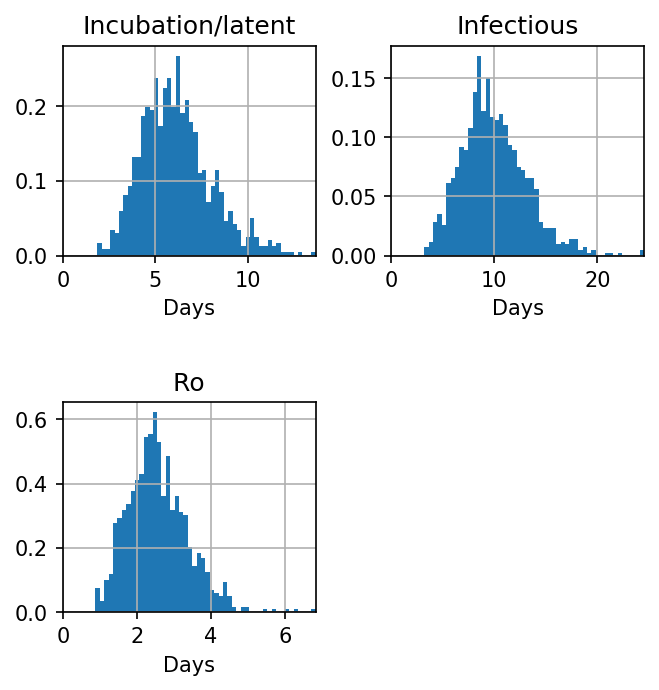

In [265]:
# Get for each naive node realistic SEIRS parameters 
#def sample_node_params():

mean_incubation = 6 ; # days. Same as latent.
infectious_period = 10; # days - D_I
#mean_total_desease = 15; # days - assuming on average 1 day of latent infectious state.
mean_Ro = 2.6 # This is correlated with population density and the implementation or not of preventive measures.

shape_incubation = 10;
shape_infectious = 10;
#shape_total_desease = 10;
shape_Ro = 10;
params = [
    [mean_incubation, shape_incubation],
    [infectious_period, shape_infectious],
    [mean_Ro, shape_Ro]]

mu = 14.;
k = 10.
param_names = ["Incubation/latent" , "Infectious","Ro"]

pplot.figure(figsize= (5,5), dpi = 150)

kk = 1;
for p, name in zip(params, param_names):
    pplot.subplot(2,2,kk)
    kk+=1
    mu = p[0]
    k = p[1]
    
    vals  = np.random.gamma(shape = k, scale = mu/k, size = (1000,1)).flatten();
    pplot.hist(vals,50,density = True)
    pplot.xlabel("Days")
    pplot.title(name)    
    pplot.xlim([0, np.max(vals)])
    pplot.grid()
    
pplot.subplots_adjust(hspace = 0.7, wspace = 0.3)

## Setting up the graph for Greece
The population movement data is modeled as a function proportional to the sum of the populations of two cities,  and inversely proportional to the distance of the cities. Normally these parameters, or approximations thereof, are available to the ministry of transportation and may be used for applying the model in real situations. It is going to be assumed that the transmission rate is slightly bigger in larger cities,  due to high population density of Greek big cities. This is modeled by 


In [266]:
!ls ../ | grep cities

greek_cities_data.dat


In [199]:
reinfection_rate = 0;
#def make_node(city_pop):
def params_to_SEIR(pp):
    """
    Transform the epidemiological parameters that are in days to rates.
    """
    r_ir = 1/pp[1] # infectious to recovered rate
    r_ei = 1/pp[0] # 1/incubation period.
    r_se = pp[-1]/pp[1] # 
    r_rs = reinfection_rate
    return r_se,r_rs,r_ei, r_ir

def get_single_param_sample():
    params_all = np.random.gamma(shape = np.array(params)[:,1], scale = np.array(params)[:,0]/np.array(params)[:,1],size = (1,3))
    return params_all.flatten()

# Compute approximate population movement strengths:
#world = pd.read_csv('worldcities.csv')
#greece = world[world['country'] == 'Greece']
nfirst = 100;

cities = pd.read_csv("../greek_cities_data.dat", sep = "\t")

#greece_tr = greece.sort_values('population', ascending = False)[0:nfirst]
population = cities.Pop2000.values;
names = cities.index;

v = cities[['Latitude (DD)','Longitude (DD)']].values


################################################
# Make graph nodes:
pops = cities.Pop2000.values
index = cities.Pop2000.index.values
node_index = [nn[0] for nn in names]
node_name = [nn[1] for nn in names]

nodes = [];
for pp, ii, nn in zip(pops,node_index, node_name):
    init_naive_node_init = [1. , 0. , 0. , 0. , pp]
    parameters_sample = get_single_param_sample();
    parameters_seir = params_to_SEIR(parameters_sample);
    new_node = SEIRN_Node(init_naive_node_init, parameters_seir)
    new_node.name = nn
    new_node.index = ii
    nodes.append(new_node)


###################################################
# Make graph edges (flows of population between cities)
# Normaly this should be callibrated with real data.
#
eye = np.eye(5);
edges = [];
for k1,v_1 in enumerate(v):
    for k2,v_2 in enumerate(v):
        if k1 is not k2:
            val = (population[k1] + population[k2])*0.01/np.sum((5+abs(v_1 - v_2))**3)
            if val < 5:
                continue
            edge_properties = eye * 0.001 * val;
            edges.append(Edge(nodes[k1],nodes[k2], edge_properties))


###################################################
# Set first cases:
# The first cases are assumed to be arround 50 asymptomatic people in each infected city.
# This is an estimate of the number of people that may be infected if they have
# travelled together with an infected person in public transportation. 
# 
greece = Graph(nodes = nodes, edges = edges)

In [200]:
# I assume more people must have managed to come through from the airports than the detected cases.
seeds = ['Patrai','Athinai','Thessaloniki','Kozani','Kavala']
seed_loads = [5,200,200,5,50]

for city_name , n_infected in zip(seeds, seed_loads):
    greece.apply_seed(n_infected, city_name )


seeding Patrai
[9.99939026e-01 0.00000000e+00 3.04868754e-05 0.00000000e+00
 1.64000000e+05]
seeding Athinai
[9.99475272e-01 0.00000000e+00 2.62363899e-04 0.00000000e+00
 7.62100000e+05]
seeding Thessaloniki
[9.98925598e-01 0.00000000e+00 5.37201182e-04 0.00000000e+00
 3.72100000e+05]
seeding Kozani
[9.99722261e-01 0.00000000e+00 1.38869601e-04 0.00000000e+00
 3.60000000e+04]
seeding Kavala
[9.98334721e-01 0.00000000e+00 8.32639467e-04 0.00000000e+00
 6.00000000e+04]


In [201]:
from scipy.integrate import odeint, solve_ivp
def dF(t,state):
    greece.set_node_states_vec(state)
    return greece.dF_vec(t)

def zero_pop(t,y0):
    return y0[0] -0.0001

zero_pop.terminal = False
zero_pop.direction = -1

ndays = 360
time = np.linspace(0,ndays,ndays*5);
res1 = solve_ivp(dF, [0,ndays] ,greece.get_node_states_vec(), vectorized=False, t_eval=time, events = [zero_pop], method = 'DOP853',rtol=1e-10)


In [159]:
def get_node_from_city(cityname):
    for k,n in enumerate(greece.nodes):
        if n.name == cityname:
            return n,k 
        
get_node_from_city("Athinai")[0].node_state

array([1.72040810e-01, 1.86866226e-04, 2.71402678e-04, 8.27495593e-01,
       7.62100000e+05])

In [160]:
S = res1.y[0::5]
E = res1.y[1::5]
I = res1.y[2::5]
R = res1.y[3::5]
N = res1.y[4::5]

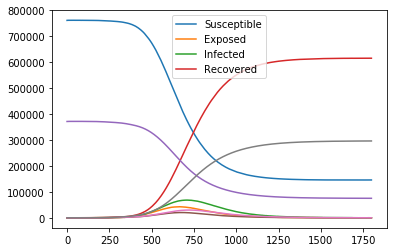

In [220]:
def get_SEIR_numbers_history_for_city(city_name, graph_obj, results):
    y = results.y;
    ii = [v.name for k,v in enumerate(graph_obj.nodes)].index(city_name)
    SEIRN = y[ii*5:(ii+1)*5].T
    SEIR = SEIRN[:,0:-1] * SEIRN[:,-1][np.newaxis].T
    return SEIR

s = get_SEIR_numbers_history_for_city("Athinai", graph_obj=greece, results = res1)
pplot.plot(s)
s = get_SEIR_numbers_history_for_city("Thessaloniki", graph_obj=greece, results = res1)
pplot.plot(s)
pplot.legend(["Susceptible","Exposed","Infected","Recovered"])



In [229]:
cities

,,Pop2000,Latitude (DD),Longitude (DD)
1,Athinai,762100,37.98,23.73
2,Thessaloniki,372100,40.64,22.94
3,Piraieus,179600,37.96,23.64
4,Patrai,164000,38.24,21.73
5,Peristerion,141000,38.02,23.70
...,...,...,...,...
119,Drapetsona,13200,37.95,23.61
120,Naupaktos,13200,38.39,21.83
58,Kholargos,32900,38.00,23.80
59,Karditsa,32700,39.37,21.92


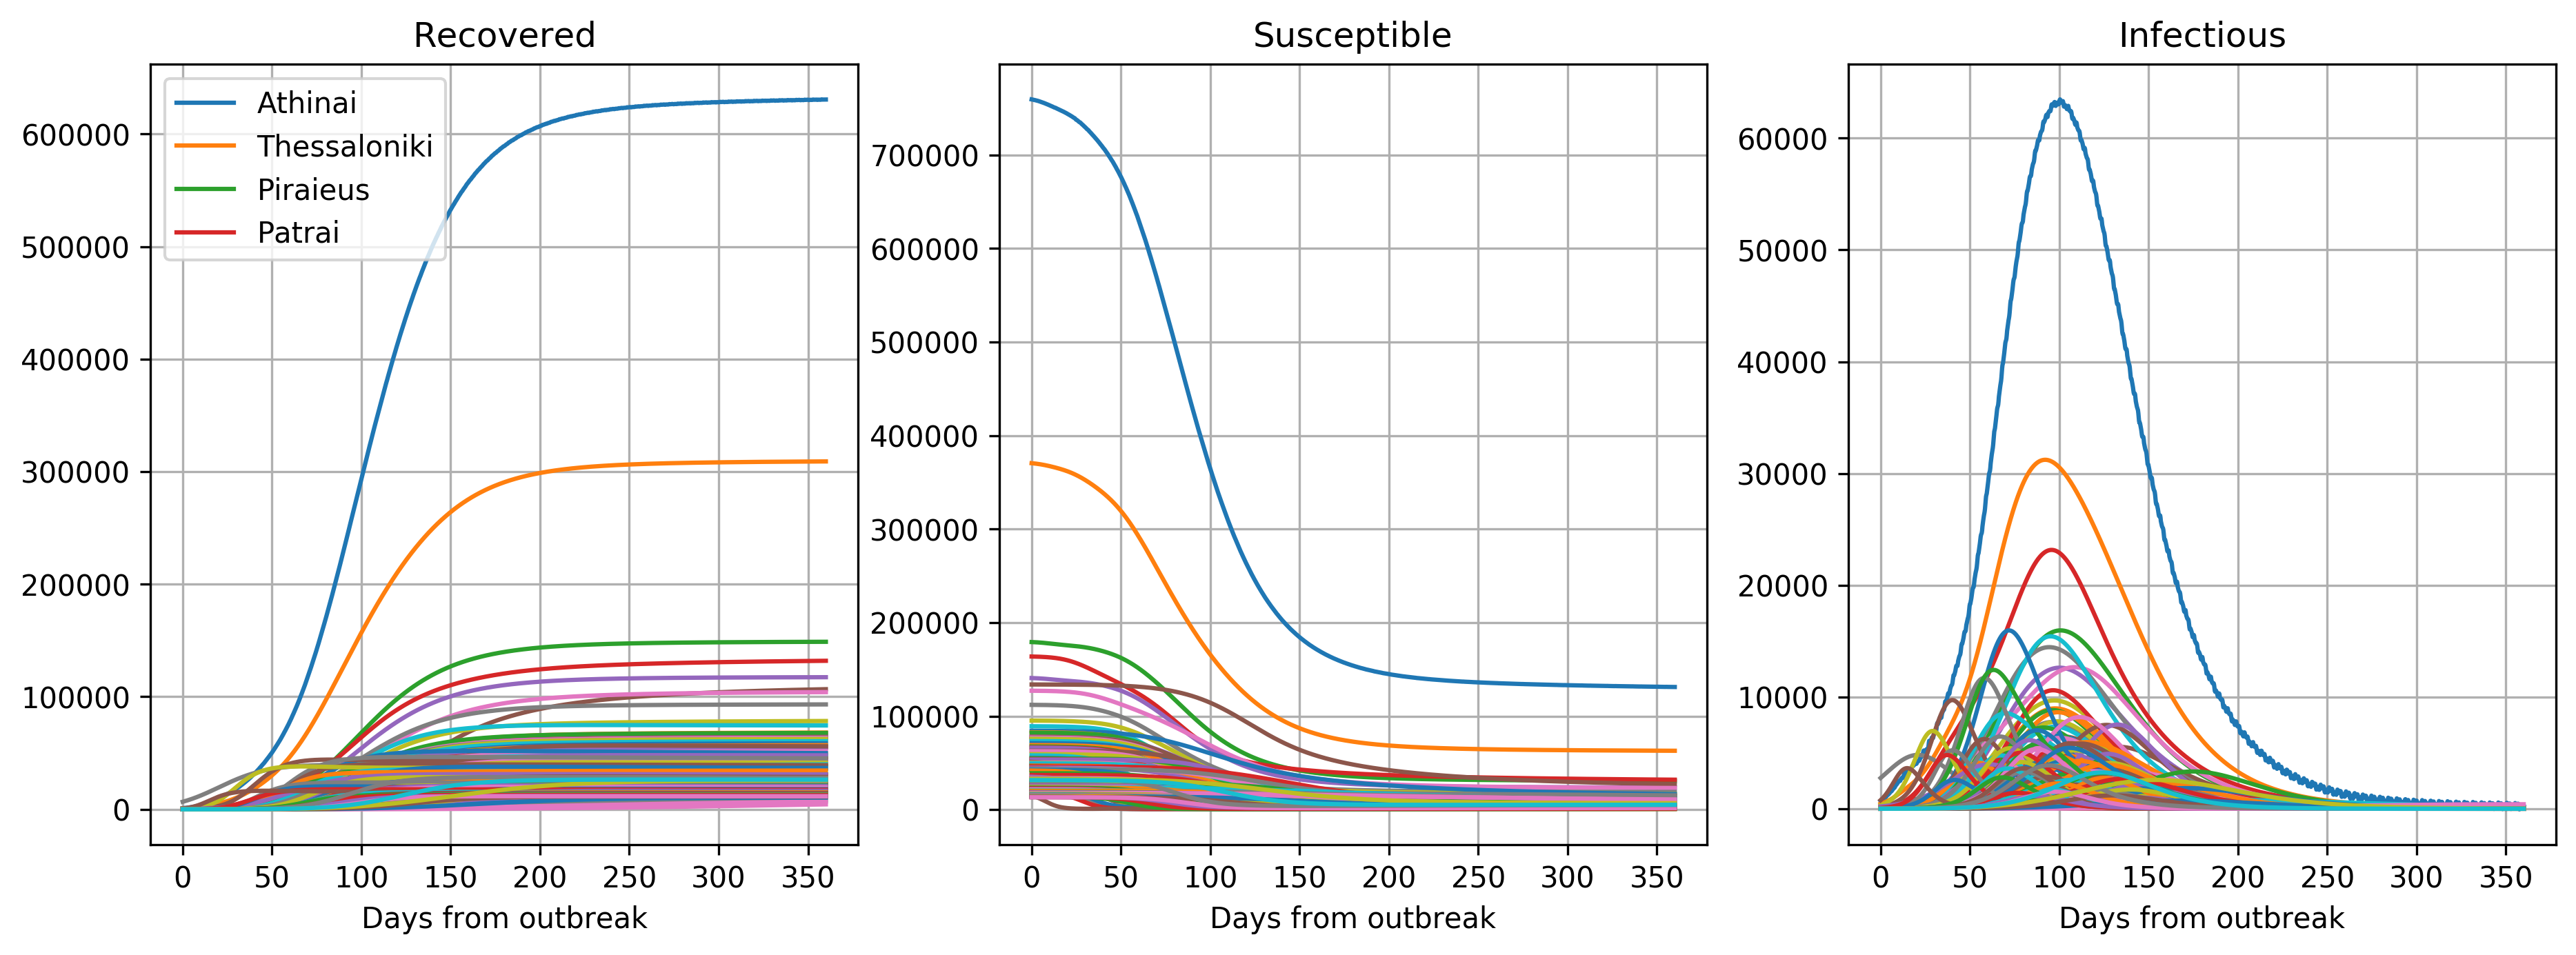

In [258]:
pplot.figure(figsize = (15,5), dpi = 300)
pplot.subplot(1,3,1)
pplot.plot(np.linspace(0,360,360 * 5),R.T*N.T)
pplot.xlabel("Days from outbreak")
pplot.title("Recovered")
pplot.grid()
pplot.legend(["Athinai","Thessaloniki","Piraieus","Patrai"])
#pplot.show()
pplot.subplot(1,3,2)
pplot.plot(np.linspace(0,360,360 * 5),S.T*N.T)
pplot.xlabel("Days from outbreak")
pplot.title("Susceptible")
pplot.grid()

pplot.subplot(1,3,3)
#pplot.show()
pplot.plot(np.linspace(0,360,360 * 5),I.T*N.T)
pplot.xlabel("Days from outbreak")
pplot.title("Infectious")
pplot.grid()


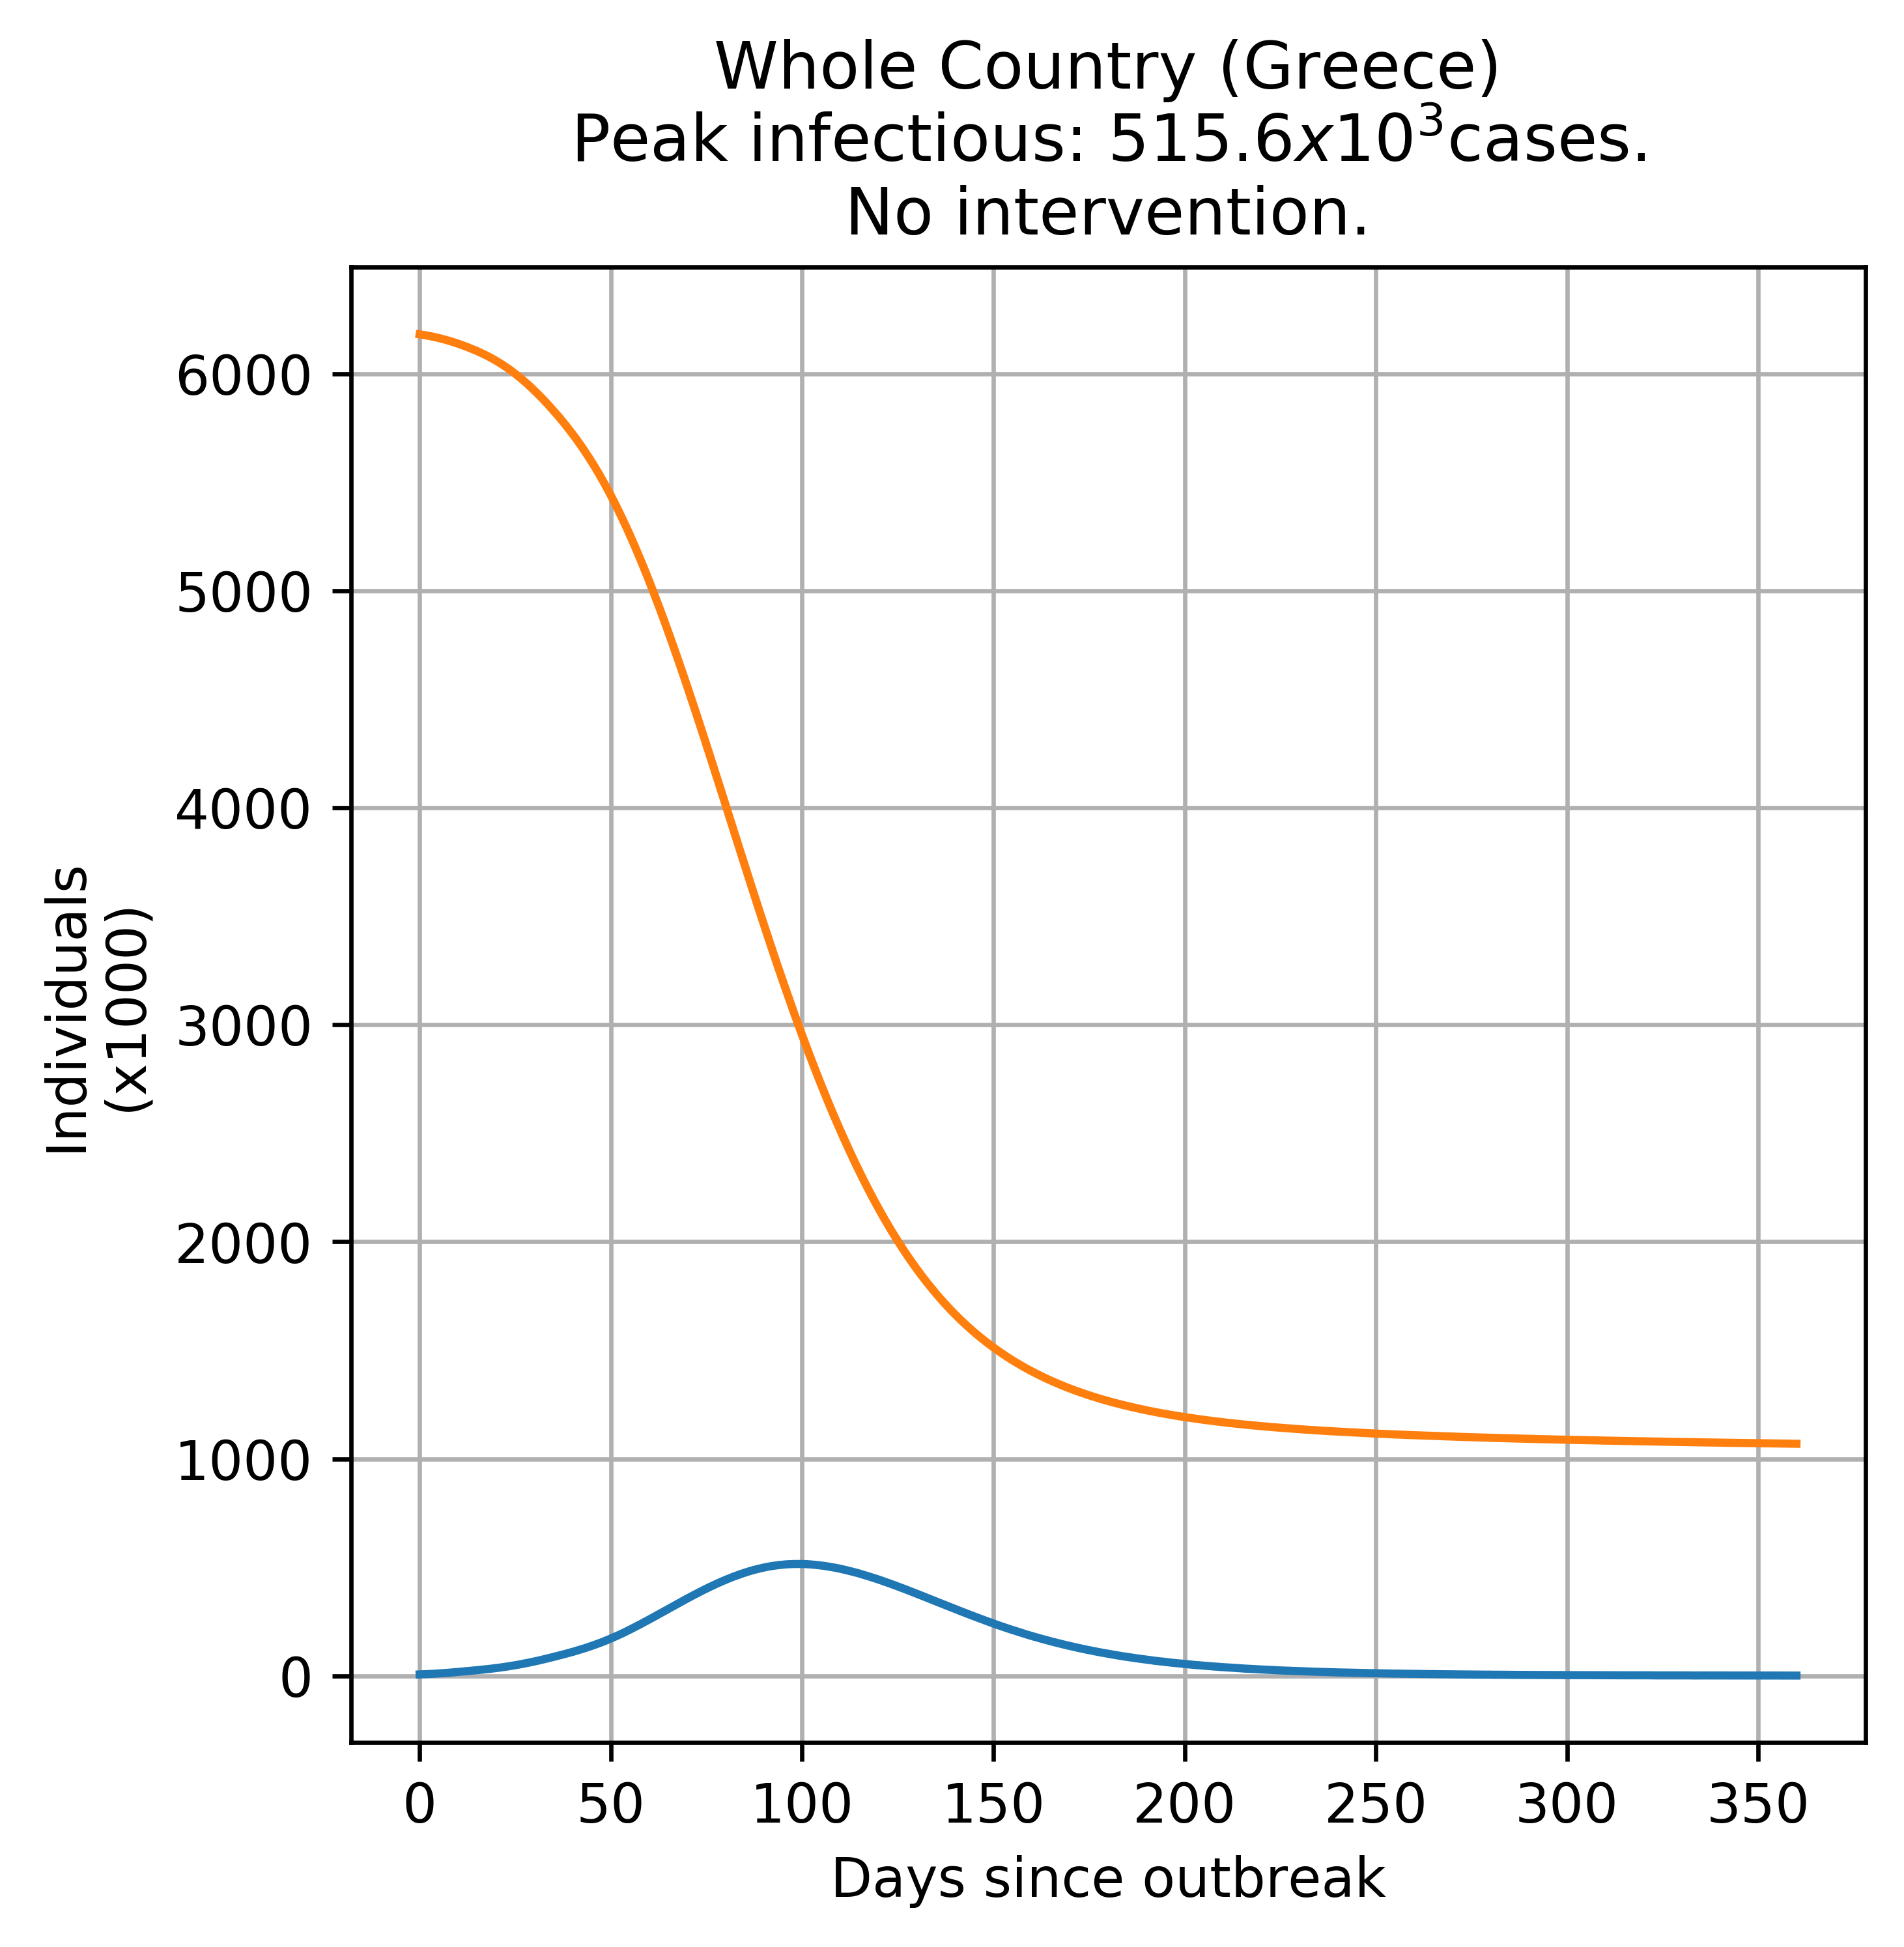

In [259]:
IN = np.sum(I*N,0)/1000
pplot.figure(figsize = (5,5), dpi = 600)
pplot.title("Whole Country (Greece)\nPeak infectious: " +"$%2.1fx10^3$"%np.max(IN) + "cases.\nNo intervention.")

pplot.plot(time,np.sum(I*N,0)/1000)
pplot.plot(time,np.sum(S*N,0)/1000)
pplot.xlabel("Days since outbreak")
pplot.ylabel("Individuals\n(x1000)")
pplot.grid()